In [716]:
import pandas as pd
import numpy as np
df = pd.read_csv('concrete.csv')
#df = df[(df.csMPa < df.csMPa.quantile(.95))&(df.csMPa > df.csMPa.quantile(.05))]
X = df.iloc[:, 0:8]
y = df.iloc[:, 8]
from sklearn.model_selection import train_test_split
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size = 0.2, random_state = 33)
X_train, X_var, y_train, y_var = train_test_split(X_train, y_train, test_size = 0.3, random_state = 33)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.3, random_state = 33)

In [717]:
X_train.shape, X_var.shape, X_test.shape, X_holdout.shape

((403, 8), (248, 8), (173, 8), (206, 8))

In [838]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn import metrics

#model_mean = MLPRegressor().fit(X_train, y_train)
model_mean = GradientBoostingRegressor(n_estimators = 200, subsample = 0.5).fit(X_train, y_train)
model_mean = LinearRegression().fit(X_train, y_train)
scores = cross_val_score(model_mean, X_train, y_train, cv=5, scoring='r2')
print(scores)
model_mean.score(X_train, y_train), model_mean.score(X_test, y_test), model_mean.score(X_var, y_var)

[0.63883589 0.63989719 0.57149132 0.57322161 0.6013372 ]


(0.6261013704002498, 0.6037527758374912, 0.5776125508994181)

In [839]:
scores

array([0.63883589, 0.63989719, 0.57149132, 0.57322161, 0.6013372 ])

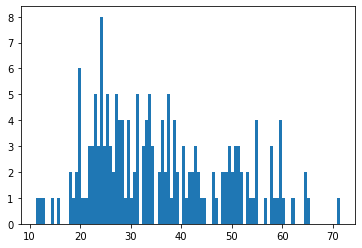

In [840]:
ypred = model_mean.predict(X_test)
u_var = y_var - model_mean.predict(X_var)
u_test = y_test - ypred
import matplotlib.pyplot as plt
plt.hist(ypred, bins = 100)
plt.show()

In [841]:
np.mean(u_test), np.mean(u_var)

(0.5312967763391595, -0.640216474305711)

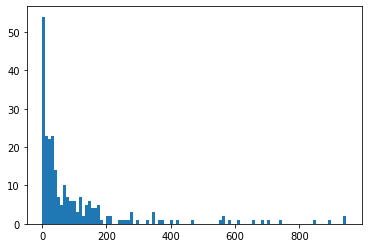

In [842]:
import matplotlib.pyplot as plt
plt.hist(u_var**2, bins = 100)
plt.show()

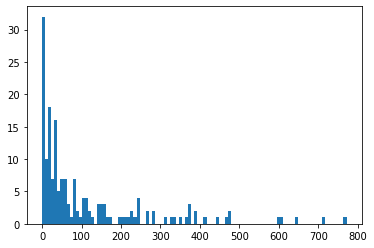

In [843]:
import matplotlib.pyplot as plt
plt.hist(u_test**2, bins = 100)
plt.show()

In [867]:
import matplotlib.pyplot as plt
N = y_test.shape
J = 10
u2varpred = np.power(u_var,2)/N*J
u2testpred = np.power(u_test,2)/N*J

In [868]:
#model_variance = MLPRegressor(500, random_state=33, max_iter=2000, alpha = 0).fit(X_var, u2varpred)
model_variance = GradientBoostingRegressor(n_estimators = 10, random_state=0, max_depth = 6).fit(X_var, u2varpred)
#model_variance = LinearRegression().fit(X_var, u2varpred)
scores = cross_val_score(model_variance, X_var, u2varpred, cv=5, scoring='r2')
print(np.mean(scores))
model_variance.score(X_var, u2varpred), model_variance.score(X_test, u2testpred)

0.29207604104707147


(0.7195761969746022, 0.32729362544258644)

In [869]:
ypred = model_mean.predict(X_holdout)
vpred = model_variance.predict(X_holdout)

In [870]:
ypred_high = np.maximum(ypred + 2*vpred, ypred - 2*vpred)
ypred_low = np.minimum(ypred - 2*vpred, ypred - 2*vpred)
df2 = pd.DataFrame(np.c_[ypred_high, ypred, ypred_low, y_holdout], columns = ['upper', 'mean', 'lower', 'actual'])
df2['hit'] = np.where((df2['actual'] >= df2['lower']) & (df2['actual'] <= df2['upper']), 1, 0)
df2['spread']  = df2.upper - df2.lower

In [871]:
df2.hit.mean()

0.7475728155339806

In [872]:
df2

,upper,mean,lower,actual,hit,spread
0,38.545359,30.965118,23.384877,26.23,1,15.160482
1,33.632928,22.680957,11.728987,25.18,1,21.903941
2,30.601713,23.728209,16.854705,24.54,1,13.747008
3,47.321924,38.337233,29.352543,46.64,1,17.969381
4,59.755067,50.746690,41.738313,55.55,1,18.016754
...,...,...,...,...,...,...
201,115.720703,68.897698,22.074693,42.13,1,93.646010
202,77.324898,66.378630,55.432361,79.40,0,21.892537
203,39.254660,30.916285,22.577910,29.87,1,16.676750
204,36.456408,27.191121,17.925833,19.52,1,18.530576


In [874]:
df2[df2.spread < 80].hit.mean()

0.7373737373737373

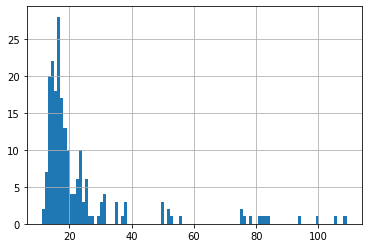

In [875]:
df2.spread.hist(bins = 100)
plt.show()